# Base Model with ASAG Dataset
<p><b>Quick note</b>: I'm now referring to the CEFR dataset as the ASAG dataset.</p>
<p>I decided to start with the ASAG dataset because it's small. I'm also having trouble accessing all of the data that I need from the PELIC dataset. It appears that I have to clone the whole repository, and use Git LFS to access everything, which I'm not familiar with.</p>
<p>In this notebook, I go through the following steps:</p>
<ol>
    <li>Load the ASAG data</li>
    <li>Store the columns I'm interested in in a separate dataframe</li>
    <li>Remove documents that were written by primary school students - I thought it would be best to focus on highschool- and university-level texts for the sake of consistency.</li>
    <li>Add counts of linguistic features to the dataset. I used spaCy to extract the token tags and syntactic dependencies from each document. Token tags give detailed information on the part of speech of each token. I assumed that higher-level texts would be associated with a greater variety of token tags and syntactic dependencies.</li>
    <li>Use Tfidf Vectorizer on the lists of token tags and dependencies to get a count of how many types were used in each text. In a way, this "one-hot encodes" the lists of tags and dependencies.</li>
    <li>Use a linear regression model to see which syntactic features have a linear relationship to the level of the text. For example, do more past participles or subordinating conjunctions in a text indicate a higher level?</li>
    <li>Use KMeans to cluster the token tags and dependencies and visualize them with T-SNE to get an idea of how distinctly they represent levels.</li>
    <li>Use a neural network to classify the documents.</li>
</ol>
<p>Things I'd like feedback on and help with:</p>
<ol>
    <li>How to get the PELIC data by cloning the repository and using Git LFS.</li>
    <li>Is a linear regression model an effective way to find features that are good predictors of level?</li>
    <li>The model looks like it's giving 100% accuracy, but I'm not sure if this means that it's overfit.</li>
    <li>If I'm going to get more data and use Colab premium, I don't know which plan would be the best for me, or how many runs I'll need.</li>
</ol>
<p>Things I'd like to continue working on:</p>
<ol>
    <li>Getting the PELIC data included.</li>
    <li>Including measures of vocabulary range and accuracy.</li>
    <li>Checking whether different levels of sentiment could be associated with different levels.</li>
    <li>Looking for pre-trained models as options.</li>
</ol>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup as bs
import spacy
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load data
labelled_path = 'data/cefr-asag-dataset-1.0.1/corpus/release-1.0/labelled/'
unlabelled_path = 'data/cefr-asag-dataset-1.0.1/corpus/release-1.0/unlabelled/'

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
# Create a function that reads the CEFR data from the XML files into a Pandas DataFrame
def create_cefr_df(path):
    '''
    This function reads the CEFR data
    from XML files in the directory
    to a Pandas DataFrame
    '''

    # Define DataFrame columns
    df_columns = ['file_name', 'age_participant','sex_participant', 'education', 'L1', 'sex_examiner1', 'sex_examiner2', 'sex_examiner3', 'setting', 'question', 'word_limit', 'level', 'answer', 'grade_examiner1', 'grade_examiner2', 'grade_examiner3', 'grade_majority_vote']

    # Create an empty list to store dictionaries
    all_data = []

    # Loop through XML files in the directory
    for filename in os.listdir(path):
        if filename.endswith('.xml'):
            file_path = os.path.join(path, filename)

            # Read XML file
            with open(file_path, 'r') as file:
                contents = file.read()

            # Parse XML
            soup = bs(contents, 'xml')

            # Extract data from XML
            age_participant = soup.find('person', {'role': 'participant'})
            sex_participant = age_participant.get('sex') if age_participant else None
            age_participant = age_participant.get('age') if age_participant else None
            education = soup.find('education').get('type') if soup.find('education') else None
            L1 = soup.find('langKnown').get('tag') if soup.find('langKnown') else None
            sex_examiner1 = soup.find('person', {'xml:id': 'examiner.1'}).get('sex') if soup.find('person', {'xml:id': 'examiner.1'}) else None
            sex_examiner2 = soup.find('person', {'xml:id': 'examiner.2'}).get('sex') if soup.find('person', {'xml:id': 'examiner.2'}) else None
            sex_examiner3 = soup.find('person', {'xml:id': 'examiner.3'}).get('sex') if soup.find('person', {'xml:id': 'examiner.3'}) else None
            setting = soup.find('settingDesc').find('p').text if soup.find('settingDesc') else None
            question = soup.find('div', {'type': 'question'}).find('p').text if soup.find('div', {'type': 'question'}) else None
            word_limit = soup.find('note', {'type': 'word-limit'}).text if soup.find('note', {'type': 'word-limit'}) else None
            level = soup.find('label', {'type': 'level'}).find('span').text if soup.find('label', {'type': 'level'}) else None
            answer = soup.find('div', {'type': 'answer'}).find('p').text if soup.find('div', {'type': 'answer'}) else None
            grade_examiner1 = soup.find('label', {'corresp': '#examiner.1'}).find('span').text if soup.find('label', {'corresp': '#examiner.1'}) else None
            grade_examiner2 = soup.find('label', {'corresp': '#examiner.2'}).find('span').text if soup.find('label', {'corresp': '#examiner.2'}) else None
            grade_examiner3 = soup.find('label', {'corresp': '#examiner.3'}).find('span').text if soup.find('label', {'corresp': '#examiner.3'}) else None
            grade_majority_vote = soup.find('label', {'subtype': 'majority-vote'}).find('span').text if soup.find('label', {'subtype': 'majority-vote'}) else None

            # Append data to list as a dictionary
            all_data.append({
                'file_name': filename,
                'age_participant': age_participant,
                'sex_participant': sex_participant,
                'education': education,
                'L1': L1,
                'sex_examiner1': sex_examiner1,
                'sex_examiner2': sex_examiner2,
                'sex_examiner3': sex_examiner3,
                'setting': setting,
                'question': question,
                'word_limit': word_limit,
                'level': level,
                'answer': answer,
                'grade_examiner1': grade_examiner1,
                'grade_examiner2': grade_examiner2,
                'grade_examiner3': grade_examiner3,
                'grade_majority_vote': grade_majority_vote
            })

    # Create DataFrame from the list of dictionaries
    df_all = pd.DataFrame(all_data)

    return df_all

In [5]:
# Call the function and display the resulting DataFrame
asag_labelled = create_cefr_df(labelled_path)
asag_labelled.head()

,file_name,age_participant,sex_participant,education,L1,sex_examiner1,sex_examiner2,sex_examiner3,setting,question,word_limit,level,answer,grade_examiner1,grade_examiner2,grade_examiner3,grade_majority_vote
0,0001.xml,18,M,higher-secondary,fr,F,F,F,collected in a university-level language learn...,What are your daily habits? What time do you g...,(at least 30 words),A1,everyday i get up at 8 a clock. I always turn ...,A1,A2,A2,A2
1,0002.xml,19,F,higher-secondary,fr,F,F,F,collected in a university-level language learn...,Describe your family.,(at least 30 words),A1,My family is very small. I have a big borther....,A1,A1,A1,A1
2,0003.xml,22,F,lower-secondary,fr,F,F,F,collected in a university-level language learn...,Describe your family.,(at least 30 words),A1,My name is {name},A1,A1,A1,A1
3,0004.xml,21,F,higher-secondary,fr,F,F,F,collected in a university-level language learn...,Describe your hobbies.,(at least 30 words),A1,"Hi my name is {name},",A2,A2,A2,A2
4,0005.xml,18,F,higher-secondary,fr,F,F,F,collected in a university-level language learn...,Describe your family.,(at least 30 words),A1,"I have one sister, she is married and she has ...",A2,A1,A2,A2


In [6]:
asag_labelled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_name            299 non-null    object
 1   age_participant      299 non-null    object
 2   sex_participant      299 non-null    object
 3   education            299 non-null    object
 4   L1                   299 non-null    object
 5   sex_examiner1        299 non-null    object
 6   sex_examiner2        299 non-null    object
 7   sex_examiner3        299 non-null    object
 8   setting              299 non-null    object
 9   question             299 non-null    object
 10  word_limit           299 non-null    object
 11  level                299 non-null    object
 12  answer               299 non-null    object
 13  grade_examiner1      299 non-null    object
 14  grade_examiner2      299 non-null    object
 15  grade_examiner3      299 non-null    object
 16  grade_ma

## Clean the data

In [7]:
# Create a new dataframe to store the transformed data
columns = ['L1','education','level','question','answer','grade_majority_vote']
df = asag_labelled[columns].copy()

In [8]:
df.head()

,L1,education,level,question,answer,grade_majority_vote
0,fr,higher-secondary,A1,What are your daily habits? What time do you g...,everyday i get up at 8 a clock. I always turn ...,A2
1,fr,higher-secondary,A1,Describe your family.,My family is very small. I have a big borther....,A1
2,fr,lower-secondary,A1,Describe your family.,My name is {name},A1
3,fr,higher-secondary,A1,Describe your hobbies.,"Hi my name is {name},",A2
4,fr,higher-secondary,A1,Describe your family.,"I have one sister, she is married and she has ...",A2


In [9]:
# Replace levels with integers.
# This will be useful later on when we want to treat X and y as numeric values.
replacement_dict = {
    'A1': 1,
    'A2': 2,
    'B1': 3,
    'B2': 4,
    'C1': 5,
    'C2': 6
}

# Perform the string replacements across the whole DataFrame
df.replace(replacement_dict, inplace=True)

# Print the updated DataFrame
df

,L1,education,level,question,answer,grade_majority_vote
0,fr,higher-secondary,1,What are your daily habits? What time do you g...,everyday i get up at 8 a clock. I always turn ...,2
1,fr,higher-secondary,1,Describe your family.,My family is very small. I have a big borther....,1
2,fr,lower-secondary,1,Describe your family.,My name is {name},1
3,fr,higher-secondary,1,Describe your hobbies.,"Hi my name is {name},",2
4,fr,higher-secondary,1,Describe your family.,"I have one sister, she is married and she has ...",2
...,...,...,...,...,...,...
294,fr,graduate-master,6,Do people who live in the public eye have a ri...,"My answer to this question is yes, famous peop...",5
295,fr,graduate-master,6,Eating a balanced diet is the most important f...,To me a healthy lifestyle starts with eating i...,6
296,fr,undergraduate-bachelor,6,Do people who live in the public eye have a ri...,"We all have a right to privacy, people in the ...",6
297,fr,undergraduate-bachelor,6,What is the impact of social networks on relat...,Social networks tends to create a distance bet...,4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   L1                   299 non-null    object
 1   education            299 non-null    object
 2   level                299 non-null    int64 
 3   question             299 non-null    object
 4   answer               299 non-null    object
 5   grade_majority_vote  299 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 14.1+ KB


In [11]:
df.education.value_counts()

education
higher-secondary          180
undergraduate-bachelor     51
graduate-master            41
lower-secondary            11
graduate-doctorate          9
primary                     7
Name: count, dtype: int64

In [12]:
# Remove primary school student texts from the df.
df = df[df.education != 'primary']

In [13]:
df.education.value_counts()

education
higher-secondary          180
undergraduate-bachelor     51
graduate-master            41
lower-secondary            11
graduate-doctorate          9
Name: count, dtype: int64

## Add linguistic feature counts to the dataset

In [14]:
# Define a function to add the number of sentences per text
# and the average sentence length per text to the dataframe
def sentence_length(df):
    # Load the English language model
    nlp = spacy.load("en_core_web_sm")

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    df = df.copy()

    # Iterate over rows in the DataFrame
    for index, row in df.iterrows():
        # Get the answer text from the DataFrame
        answer_text = row['answer']

        # Process the answer text with spaCy
        doc = nlp(answer_text)

        # Initialize variables to accumulate total tokens and count of sentences
        total_tokens = 0
        num_sentences = 0

        # Iterate over sentences and accumulate total tokens
        for sentence in doc.sents:
            num_tokens = len(sentence)
            total_tokens += num_tokens
            num_sentences += 1

        # Calculate the average sentence length
        avg_len = total_tokens / num_sentences

        # Add num_sentences and avg_len as new columns in the DataFrame
        df.loc[index, 'num_sentences'] = num_sentences
        df.loc[index, 'avg_sentence_length'] = avg_len

    return df

In [15]:
# Run the function
df = sentence_length(df)
df.head()

,L1,education,level,question,answer,grade_majority_vote,num_sentences,avg_sentence_length
0,fr,higher-secondary,1,What are your daily habits? What time do you g...,everyday i get up at 8 a clock. I always turn ...,2,9.0,6.888889
1,fr,higher-secondary,1,Describe your family.,My family is very small. I have a big borther....,1,4.0,6.000000
2,fr,lower-secondary,1,Describe your family.,My name is {name},1,1.0,6.000000
3,fr,higher-secondary,1,Describe your hobbies.,"Hi my name is {name},",2,1.0,8.000000
4,fr,higher-secondary,1,Describe your family.,"I have one sister, she is married and she has ...",2,5.0,13.600000


In [16]:
# Get a sense of whether the number of sentences or the average sentence length
# could be an indicator of level.

A1 = df[df.grade_majority_vote == 1]
A2 = df[df.grade_majority_vote == 2]
B1 = df[df.grade_majority_vote == 3]
B2 = df[df.grade_majority_vote == 4]
C1 = df[df.grade_majority_vote == 5]
C2 = df[df.grade_majority_vote == 6]

print("Average sentence length:")
print(f"A1: {A1.avg_sentence_length.mean()}")
print(f"A2: {A2.avg_sentence_length.mean()}")
print(f"B1: {B1.avg_sentence_length.mean()}")
print(f"B2: {B2.avg_sentence_length.mean()}")
print(f"C1: {C1.avg_sentence_length.mean()}")
print(f"C2: {C2.avg_sentence_length.mean()}")
print("\nAverage number of sentences:")
print(f"A1: {A1.num_sentences.mean()}")
print(f"A2: {A2.num_sentences.mean()}")
print(f"B1: {B1.num_sentences.mean()}")
print(f"B2: {B2.num_sentences.mean()}")
print(f"C1: {C1.num_sentences.mean()}")
print(f"C2: {C2.num_sentences.mean()}")

Average sentence length:
A1: 13.265686274509804
A2: 14.260577580314424
B1: 16.89213132826769
B2: 19.87751882820376
C1: 23.17074481074481
C2: 21.098095238095237

Average number of sentences:
A1: 4.294117647058823
A2: 5.666666666666667
B1: 4.909090909090909
B2: 4.027397260273973
C1: 3.6333333333333333
C2: 5.4


In [17]:
# Define a function to extract token tags
def extract_tags(text):
    '''
    Converts each text to a small English core object
    and returns a list of token dependencies
    for each text.
    '''
    doc = nlp(text)
    return [token.tag_ for token in doc]

In [18]:
# Apply the function
df['token_tag'] = df['answer'].apply(extract_tags)

In [19]:
# Flatten the lists
df['token_tag_flat'] = df['token_tag'].apply(lambda x: ' '.join(x))

In [20]:
df.token_tag_flat

0      RB PRP VBP RP IN CD DT NN . PRP RB VBP PRP$ NN...
1      PRP$ NN VBZ RB JJ . PRP VBP DT JJ NN . PRP VBZ...
2                             PRP$ NN VBZ -LRB- NN -RRB-
3                        UH PRP$ NN VBZ -LRB- NN -RRB- ,
4      PRP VBP CD NN , PRP VBZ JJ CC PRP VBZ CD NNS ....
                             ...                        
294    PRP$ NN IN DT NN VBZ UH , JJ NNS VBP VB DT NN ...
295    IN PRP DT JJ NN VBZ IN VBG IN DT JJ , JJ NN . ...
296    PRP DT VBP DT NN IN NN , NNS IN DT JJ NN VBP R...
297    JJ NNS VBZ TO VB DT NN IN NNS , CC NNP PRP VBZ...
298    JJ NN , VB PRP VB IN PRP DT JJ IN WP PRP VBP I...
Name: token_tag_flat, Length: 292, dtype: object

In [21]:
# Define a function to extract syntactic dependencies
def extract_deps(text):
    '''
    Converts each text to a small English core object
    and returns a list of token dependencies
    for each text.
    '''
    doc = nlp(text)
    return [token.dep_ for token in doc]

In [22]:
# Apply the function to a new column in the df
df['token_dep'] = df['answer'].apply(extract_deps)

In [23]:
df.token_dep

0      [npadvmod, nsubj, ROOT, prt, prep, pobj, det, ...
1      [poss, nsubj, ROOT, advmod, acomp, punct, nsub...
2                [poss, nsubj, ROOT, punct, attr, punct]
3      [intj, poss, nsubj, ROOT, punct, attr, punct, ...
4      [nsubj, ccomp, nummod, dobj, punct, nsubj, ROO...
                             ...                        
294    [poss, nsubj, prep, det, pobj, ROOT, intj, pun...
295    [prep, pobj, det, amod, nsubj, ROOT, prep, pco...
296    [nsubj, appos, ccomp, det, dobj, prep, pobj, p...
297    [amod, nsubj, ROOT, aux, xcomp, det, dobj, pre...
298    [amod, npadvmod, punct, ROOT, nsubj, ccomp, pr...
Name: token_dep, Length: 292, dtype: object

In [24]:
# Flatten the token dependency column
df['token_dep_flat'] = df['token_dep'].apply(lambda x: ' '.join(x))
df.token_dep_flat

0      npadvmod nsubj ROOT prt prep pobj det pobj pun...
1      poss nsubj ROOT advmod acomp punct nsubj ROOT ...
2                       poss nsubj ROOT punct attr punct
3            intj poss nsubj ROOT punct attr punct punct
4      nsubj ccomp nummod dobj punct nsubj ROOT acomp...
                             ...                        
294    poss nsubj prep det pobj ROOT intj punct amod ...
295    prep pobj det amod nsubj ROOT prep pcomp prep ...
296    nsubj appos ccomp det dobj prep pobj punct nsu...
297    amod nsubj ROOT aux xcomp det dobj prep pobj p...
298    amod npadvmod punct ROOT nsubj ccomp prep pobj...
Name: token_dep_flat, Length: 292, dtype: object

## Get the number of token tags per document with Tfidf Vectorizer

In [25]:
vectorizer = TfidfVectorizer()

In [26]:
tag_counts = df.token_tag_flat

In [27]:
tag_counts = vectorizer.fit_transform(tag_counts)

In [28]:
tag_counts = pd.DataFrame(tag_counts.toarray(), columns=vectorizer.get_feature_names_out())
# Display the TF-IDF DataFrame
tag_counts

,_sp,cc,cd,dt,ex,fw,hyph,in,jj,jjr,...,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb,xx
0,0.00000,0.058820,0.180192,0.202630,0.000000,0.0,0.000000,0.249837,0.102013,0.000000,...,0.167997,0.000000,0.000000,0.000000,0.394740,0.061826,0.000000,0.000000,0.000000,0.0
1,0.00000,0.000000,0.438125,0.246342,0.000000,0.0,0.000000,0.000000,0.372058,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.137112,0.450976,0.000000,0.000000,0.000000,0.0
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.276291,0.000000,0.000000,0.000000,0.0
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.239186,0.000000,0.000000,0.000000,0.0
4,0.00000,0.273747,0.251585,0.188609,0.000000,0.0,0.000000,0.093020,0.189908,0.000000,...,0.000000,0.086226,0.000000,0.000000,0.209958,0.345285,0.000000,0.000000,0.094229,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.00000,0.183377,0.000000,0.315862,0.000000,0.0,0.000000,0.342715,0.190823,0.000000,...,0.174584,0.115522,0.102045,0.109352,0.246130,0.115649,0.075681,0.136247,0.063122,0.0
288,0.00000,0.115824,0.000000,0.224441,0.000000,0.0,0.152341,0.418170,0.477085,0.063695,...,0.165405,0.000000,0.080566,0.000000,0.138803,0.213051,0.000000,0.053785,0.000000,0.0
289,0.00000,0.171493,0.000000,0.320007,0.062872,0.0,0.000000,0.388489,0.272641,0.000000,...,0.326538,0.000000,0.079526,0.127832,0.246620,0.030043,0.000000,0.000000,0.147577,0.0
290,0.00000,0.261445,0.000000,0.225166,0.000000,0.0,0.000000,0.333148,0.226717,0.000000,...,0.248908,0.000000,0.000000,0.000000,0.000000,0.274807,0.000000,0.000000,0.000000,0.0


In [29]:
tag_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   _sp     292 non-null    float64
 1   cc      292 non-null    float64
 2   cd      292 non-null    float64
 3   dt      292 non-null    float64
 4   ex      292 non-null    float64
 5   fw      292 non-null    float64
 6   hyph    292 non-null    float64
 7   in      292 non-null    float64
 8   jj      292 non-null    float64
 9   jjr     292 non-null    float64
 10  jjs     292 non-null    float64
 11  lrb     292 non-null    float64
 12  md      292 non-null    float64
 13  nfp     292 non-null    float64
 14  nn      292 non-null    float64
 15  nnp     292 non-null    float64
 16  nnps    292 non-null    float64
 17  nns     292 non-null    float64
 18  pdt     292 non-null    float64
 19  pos     292 non-null    float64
 20  prp     292 non-null    float64
 21  rb      292 non-null    float64
 22  rb

In [30]:
# Repeat the process for the syntactic dependecy counts
dep_counts = df.token_dep_flat

In [31]:
dep_counts = vectorizer.fit_transform(dep_counts)

In [32]:
dep_counts = pd.DataFrame(dep_counts.toarray(), columns=vectorizer.get_feature_names_out())
# Display the TF-IDF DataFrame
dep_counts

,acl,acomp,advcl,advmod,agent,amod,appos,attr,aux,auxpass,...,poss,preconj,predet,prep,prt,punct,quantmod,relcl,root,xcomp
0,0.000000,0.000000,0.000000,0.279793,0.000000,0.112696,0.00000,0.000000,0.112696,0.120764,...,0.196094,0.0,0.0,0.207501,0.310205,0.386247,0.0,0.081233,0.425720,0.000000
1,0.000000,0.329258,0.000000,0.128035,0.000000,0.128926,0.00000,0.160960,0.000000,0.000000,...,0.149557,0.0,0.0,0.000000,0.000000,0.441873,0.0,0.000000,0.432916,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.459692,0.000000,0.000000,...,0.427126,0.0,0.0,0.000000,0.000000,0.630982,0.0,0.000000,0.309096,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.296873,0.000000,0.000000,...,0.275841,0.0,0.0,0.000000,0.000000,0.611240,0.0,0.000000,0.199616,0.000000
4,0.000000,0.264927,0.132463,0.154529,0.000000,0.000000,0.00000,0.064756,0.000000,0.000000,...,0.300840,0.0,0.0,0.095502,0.142772,0.399982,0.0,0.000000,0.217708,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.146398,0.042502,0.085004,0.231384,0.000000,0.166424,0.00000,0.083110,0.166424,0.000000,...,0.154444,0.0,0.0,0.214499,0.000000,0.456313,0.0,0.047985,0.195590,0.000000
288,0.000000,0.179941,0.215929,0.139944,0.000000,0.422752,0.00000,0.070372,0.197284,0.000000,...,0.130773,0.0,0.0,0.259463,0.077577,0.386377,0.0,0.000000,0.165613,0.077143
289,0.062658,0.072764,0.181909,0.226359,0.000000,0.227934,0.05651,0.071142,0.284918,0.183189,...,0.198306,0.0,0.0,0.393452,0.000000,0.244127,0.0,0.041075,0.119589,0.155975
290,0.000000,0.000000,0.000000,0.491140,0.000000,0.247279,0.00000,0.154359,0.247279,0.000000,...,0.000000,0.0,0.0,0.341475,0.000000,0.211877,0.0,0.178243,0.103791,0.169212


In [33]:
print(df.shape)
print(tag_counts.shape)
print(dep_counts.shape)

(292, 12)
(292, 39)
(292, 43)


In [34]:
# Reset indices of DataFrames
df.reset_index(drop=True, inplace=True)
tag_counts.reset_index(drop=True, inplace=True)
dep_counts.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames again and display the resulting DataFrame
result = pd.concat([df, tag_counts, dep_counts], axis=1)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 94 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   L1                   292 non-null    object 
 1   education            292 non-null    object 
 2   level                292 non-null    int64  
 3   question             292 non-null    object 
 4   answer               292 non-null    object 
 5   grade_majority_vote  292 non-null    int64  
 6   num_sentences        292 non-null    float64
 7   avg_sentence_length  292 non-null    float64
 8   token_tag            292 non-null    object 
 9   token_tag_flat       292 non-null    object 
 10  token_dep            292 non-null    object 
 11  token_dep_flat       292 non-null    object 
 12  _sp                  292 non-null    float64
 13  cc                   292 non-null    float64
 14  cd                   292 non-null    float64
 15  dt                   292 non-null    flo

## Do a linear regression to see which syntactic features could be good predictors of level

In [35]:
numerical_df = result.select_dtypes(include=['float64', 'int64'])

In [36]:
# scaler = StandardScaler()
normalizer = Normalizer()

In [37]:
# numerical_scaled = scaler.fit_transform(numerical_df)
numerical_normalized = normalizer.fit_transform(numerical_df)

In [38]:
# numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)
numerical_normalized_df = pd.DataFrame(numerical_normalized, columns=numerical_df.columns)

In [39]:
numerical_normalized_df

,level,grade_majority_vote,num_sentences,avg_sentence_length,_sp,cc,cd,dt,ex,fw,...,poss,preconj,predet,prep,prt,punct,quantmod,relcl,root,xcomp
0,0.085921,0.171842,0.773290,0.591901,0.000000,0.005054,0.015482,0.017410,0.000000,0.0,...,0.016849,0.0,0.0,0.017829,0.026653,0.033187,0.0,0.006980,0.036578,0.000000
1,0.133631,0.133631,0.534522,0.801784,0.000000,0.000000,0.058547,0.032919,0.000000,0.0,...,0.019985,0.0,0.0,0.000000,0.000000,0.059048,0.0,0.000000,0.057851,0.000000
2,0.156174,0.156174,0.156174,0.937043,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.066706,0.0,0.0,0.000000,0.000000,0.098543,0.0,0.000000,0.048273,0.000000
3,0.117851,0.235702,0.117851,0.942809,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.032508,0.0,0.0,0.000000,0.000000,0.072035,0.0,0.000000,0.023525,0.000000
4,0.067891,0.135781,0.339453,0.923313,0.000000,0.018585,0.017080,0.012805,0.000000,0.0,...,0.020424,0.0,0.0,0.006484,0.009693,0.027155,0.0,0.000000,0.014780,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.297820,0.248183,0.347457,0.850914,0.000000,0.009102,0.000000,0.015678,0.000000,0.0,...,0.007666,0.0,0.0,0.010647,0.000000,0.022650,0.0,0.002382,0.009708,0.000000
288,0.263802,0.263802,0.307769,0.873058,0.000000,0.005092,0.000000,0.009868,0.000000,0.0,...,0.005750,0.0,0.0,0.011408,0.003411,0.016988,0.0,0.000000,0.007282,0.003392
289,0.196913,0.196913,0.164094,0.945182,0.000000,0.005628,0.000000,0.010502,0.002063,0.0,...,0.006508,0.0,0.0,0.012913,0.000000,0.008012,0.0,0.001348,0.003925,0.005119
290,0.200446,0.133631,0.033408,0.968822,0.000000,0.008734,0.000000,0.007522,0.000000,0.0,...,0.000000,0.0,0.0,0.011408,0.000000,0.007078,0.0,0.005955,0.003467,0.005653


In [40]:
X = numerical_normalized_df.drop(['level','grade_majority_vote'],axis=1)
X = sm.add_constant(X)
y = numerical_normalized_df['grade_majority_vote']

In [41]:
lm = sm.OLS(y,X)

In [42]:
results = lm.fit()

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     grade_majority_vote   R-squared:                       0.901
Model:                             OLS   Adj. R-squared:                  0.861
Method:                  Least Squares   F-statistic:                     22.48
Date:                 Sat, 04 May 2024   Prob (F-statistic):           2.64e-70
Time:                         22:55:31   Log-Likelihood:                 583.00
No. Observations:                  292   AIC:                            -996.0
Df Residuals:                      207   BIC:                            -683.5
Df Model:                           84                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7740      0.072     10.683      0.000       0.631       0.917
num_sentences          -0.3802      0.034    -11.229      0.000      -0.447      -0.313
avg_sentence_length    -0.7342      0.076     -9.706      0.000      -0.883      -0.585
_sp                    -2.5918      2.049     -1.265      0.207      -6.632       1.448
cc                     -2.9198      3.283     -0.889      0.375      -9.392       3.552
cd                     -0.5769      0.874     -0.660      0.510      -2.300       1.146
dt                      2.6035      1.136      2.292      0.023       0.364       4.843
ex                      3.0694      4.400      0.698      0.486      -5.605      11.744
fw                      1.8235      1.880      0.970      0.333      -1.883       5.530
hyph                    0.5838      1.117      0.523      0.602      -1.618       2.786
in                      1.9088      1.453      1.314      0.190      -0.955       4.773
jj                      1.2958      0.987      1.313      0.191      -0.650       3.241
jjr                     0.7862      0.892      0.881      0.379      -0.973       2.545
jjs                    -0.1080      0.958     -0.113      0.910      -1.996       1.780
lrb                    -6.4700     10.512     -0.615      0.539     -27.195      14.255
md                     -0.9796      1.168     -0.839      0.403      -3.282       1.323
nfp                     2.2262      1.585      1.404      0.162      -0.899       5.352
nn                     -0.4869      0.667     -0.730      0.466      -1.802       0.828
nnp                     0.5278      0.469      1.126      0.261      -0.396       1.452
nnps                    6.8764      3.339      2.060      0.041       0.294      13.459
nns                    -0.4047      0.636     -0.637      0.525      -1.658       0.849
pdt                   -10.3843      7.757     -1.339      0.182     -25.678       4.909
pos                    -3.0469      4.149     -0.734      0.464     -11.227       5.133
prp                    -0.3749      0.756     -0.496      0.620      -1.865       1.115
rb                      1.7200      0.786      2.188      0.030       0.171       3.269
rbr                     1.3077      1.049      1.246      0.214      -0.761       3.377
rbs                     1.3775      0.801      1.720      0.087      -0.201       2.956
rp                      0.0741      2.763      0.027      0.979      -5.372       5.521
rrb                     7.4255     10.539      0.705      0.482     -13.351      28.202
sym                     2.7888      2.295      1.215      0.226      -1.736       7.313
to                      0.2256      1.292      0.175      0.862      -2.322       2.773
uh                      0.0459      0.543      0.085      0.933      -1.024     

In [44]:
# Drop features with high p-values
# Extract the p-values from the summary
p_values = results.pvalues

# Get the names of features with p-values greater than 0.05
features_to_drop = p_values[p_values > 0.05].index.tolist()

# Drop the features from the X DataFrame
X.drop(features_to_drop, axis=1, inplace=True)
X = sm.add_constant(X)
# Print the list of dropped features
print("Dropped features:", features_to_drop)

Dropped features: ['_sp', 'cc', 'cd', 'ex', 'fw', 'hyph', 'in', 'jj', 'jjr', 'jjs', 'lrb', 'md', 'nfp', 'nn', 'nnp', 'nns', 'pdt', 'pos', 'prp', 'rbr', 'rbs', 'rp', 'rrb', 'sym', 'to', 'uh', 'vb', 'vbd', 'vbg', 'vbp', 'vbz', 'wrb', 'xx', 'acl', 'acomp', 'advmod', 'agent', 'amod', 'attr', 'aux', 'auxpass', 'case', 'cc', 'compound', 'conj', 'csubj', 'dative', 'dep', 'det', 'dobj', 'expl', 'intj', 'mark', 'neg', 'nmod', 'nsubj', 'nsubjpass', 'nummod', 'oprd', 'parataxis', 'pcomp', 'pobj', 'poss', 'preconj', 'predet', 'prep', 'prt', 'quantmod', 'relcl', 'root', 'xcomp']


In [45]:
lm = sm.OLS(y,X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     grade_majority_vote   R-squared:                       0.816
Model:                             OLS   Adj. R-squared:                  0.808
Method:                  Least Squares   F-statistic:                     94.97
Date:                 Sat, 04 May 2024   Prob (F-statistic):           4.37e-94
Time:                         22:55:32   Log-Likelihood:                 492.39
No. Observations:                  292   AIC:                            -956.8
Df Residuals:                      278   BIC:                            -905.3
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.9825      0.032     30.561      0.000       0.919       1.046
num_sentences          -0.4138      0.018    -22.633      0.000      -0.450      -0.378
avg_sentence_length    -0.8640      0.032    -27.181      0.000      -0.927      -0.801
dt                      0.8235      0.271      3.041      0.003       0.290       1.357
nnps                    7.2937      3.728      1.956      0.051      -0.045      14.633
rb                      1.0376      0.306      3.389      0.001       0.435       1.640
vbn                     1.7087      0.677      2.525      0.012       0.377       3.041
wdt                     3.1110      1.176      2.645      0.009       0.796       5.426
wp                      0.4510      0.691      0.652      0.515      -0.910       1.812
advcl                   1.8106      0.599      3.021      0.003       0.631       2.990
appos                   0.1561      0.368      0.425      0.671      -0.568       0.880
ccomp                   1.2157      0.657      1.852      0.065      -0.077       2.508
npadvmod                0.3621      0.219      1.650      0.100      -0.070       0.794
punct                   1.3936      0.168      8.282      0.000       1.062       1.725
==============================================================================
Omnibus:                       13.165   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.111
Skew:                          -0.391   Prob(JB):                     0.000317
Kurtosis:                       3.844   Cond. No.                     1.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
X.drop(['const'], axis=1, inplace=True)

In [47]:
X

,num_sentences,avg_sentence_length,dt,nnps,rb,vbn,wdt,wp,advcl,appos,ccomp,npadvmod,punct
0,0.773290,0.591901,0.017410,0.000000,0.032756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016241,0.033187
1,0.534522,0.801784,0.032919,0.000000,0.017696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028897,0.059048
2,0.156174,0.937043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098543
3,0.117851,0.942809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072035
4,0.339453,0.923313,0.012805,0.000000,0.006883,0.000000,0.000000,0.000000,0.008993,0.000000,0.008504,0.005906,0.027155
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.347457,0.850914,0.015678,0.007491,0.016856,0.005428,0.003757,0.006763,0.004219,0.000000,0.003990,0.000000,0.022650
288,0.307769,0.873058,0.009868,0.000000,0.008252,0.000000,0.000000,0.002365,0.009494,0.000000,0.002993,0.000000,0.016988
289,0.164094,0.945182,0.010502,0.000000,0.005211,0.004195,0.000000,0.000000,0.005970,0.001855,0.002258,0.000000,0.008012
290,0.033408,0.968822,0.007522,0.000000,0.012131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007078


## Cluster X with KMeans to see if we get something similar to the levels

In [48]:
k = 6
kmeans = KMeans(n_clusters=k,random_state=42,n_init='auto')

In [49]:
clusters = kmeans.fit(X)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [50]:
clusters

KMeans(n_clusters=6, n_init='auto', random_state=42)

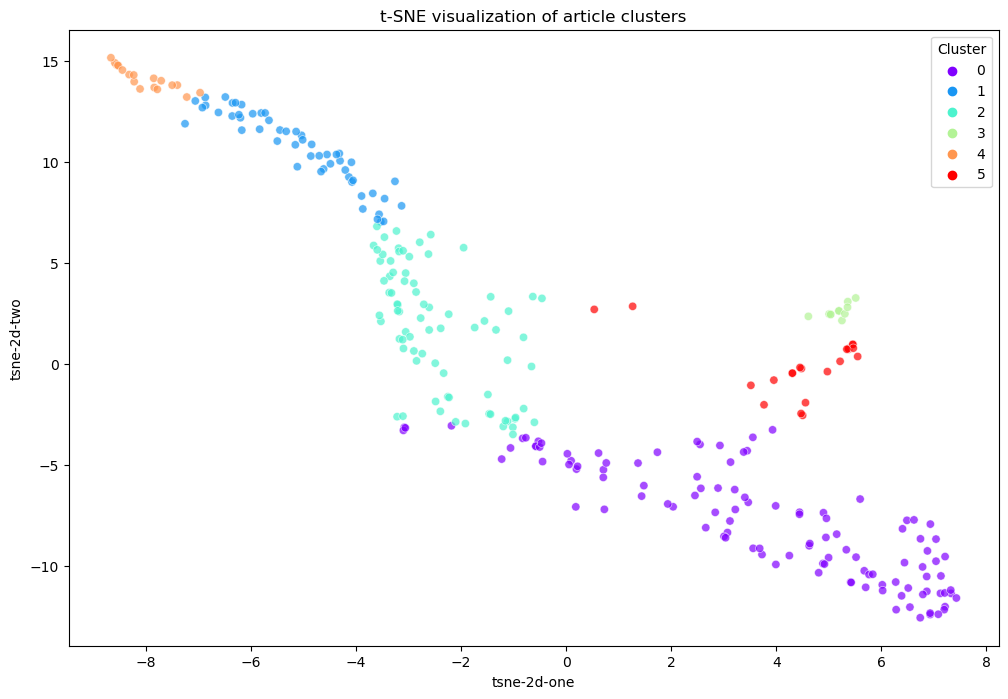

In [51]:
df = pd.DataFrame()

df['cluster'] = clusters.labels_

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Store the first and second dimensions in the df
df['tsne-2d-one'] = X_tsne[:, 0]
df['tsne-2d-two'] = X_tsne[:, 1]

# Plot the dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two', hue='cluster', palette='rainbow', data=df, alpha=0.7, legend='full')

plt.title('t-SNE visualization of article clusters')
plt.legend(title='Cluster')
plt.show()

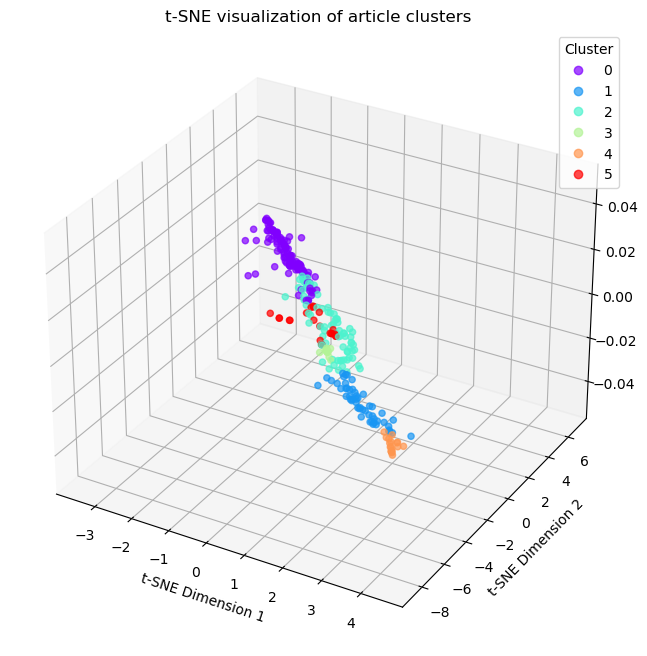

In [52]:
df = pd.DataFrame()

df['cluster'] = clusters.labels_

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=3, perplexity=40, n_iter=300, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Store the first and second dimensions in the df
df['tsne-2d-one'] = X_tsne[:, 0]
df['tsne-2d-two'] = X_tsne[:, 1]

# Plot the dimensions in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
scatter = ax.scatter(df['tsne-2d-one'], df['tsne-2d-two'], zs=0, c=df['cluster'], cmap='rainbow', alpha=0.7)

# Set labels and title
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('t-SNE visualization of article clusters')
ax.legend(*scatter.legend_elements(), title='Cluster')

plt.show()

## Try some classification algorithms

### Neural Network

In [53]:
input_shape = (13,) 
num_classes = 6

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(3, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Softmax activation for multi-class classification
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Multi-class classification setup

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [55]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.0000e+00 - loss: 2.0130 - val_accuracy: 0.0000e+00 - val_loss: 2.0034
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 1.9970 - val_accuracy: 0.0000e+00 - val_loss: 1.9812
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 1.9727 - val_accuracy: 0.0000e+00 - val_loss: 1.9594
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 1.9484 - val_accuracy: 0.0000e+00 - val_loss: 1.9381
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 1.9268 - val_accuracy: 0.0000e+00 - val_loss: 1.9173
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 1.9093 - val_accuracy: 0.0000e+00 - val_loss: 1.8969
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0066 - loss: 1.8884 - val_accuracy: 0.0000e+00 - val_loss: 1.8770
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0123 - los

In [56]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.656554102897644
Test accuracy: 1.0
